# USB Data
----

## Models for Unusual USB Device Usage
**What are the assumptions that describe unusual usage of USB devices?**

<img src="usb-insider.png" alt="Haystax's Data Science Workflow" width="25%" />
<figcaption>Image credit: www.secudrives.com.</figcaption>

USB data shows the connect and disconnect activity of employees with corresponding attributes such as `date`, `user`, `pc`, and `file_tree`.

### Initial thoughts

* Users are typically assigned a normal/average number of thumb drive uses per day. Deviations from a user's normal usage can be considered significant.
* The `file_tree` field is a semicolon-delimited list of directories on the device. We can look at these directories for some insights.
* Malicious insiders will often copy large amounts of proprietary data to a USB device  or a personal device
* Unauthorized downloading of data onto a personal USB drive or other storage medium.
* Copying data to an unsecured USB is an example of insider threat that cannot be detected with controls such as Firewalls, IDS, IPS, SIEM because they are focused on external attacks.  

* Understanding the context: 
  * With external attacks, the line between good and bad activity is very clear. An external entity should be accessing your web page, for example, but should never be running software that tries to log in with 500 different passwords in a short time. Therefore, typical preventive measures are very effective. With an insider threat, a user performs a normal set of actions, but the context in which the user executes them is quite different. As an example, one user could be accessing files for project A because she is actively working with the client. This is quite different than the user who is accessing files for project B, a project he has not worked on for several months, then immediately copies the information to a USB drive. In both cases, the access is similar, but the context makes these very different situations.

* Copying, modifying and deleting data on a USB during offboarding is a potential indicator of insider threat.
* An insider visits a restricted site (e.g. wikileaks) after having inserted a USB device
* An example of a malicious scenario from CERT:
  * User who did not previously use removable drives or work after hours begins logging in after hours, using a removable drive, and uploading data to wikileaks.org. Leaves the organization shortly thereafter.

First, let's set up our working environment including required libraries.

In [46]:
# %load modeling.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
os.environ['MKL_THREADING_LAYER']='GNU'
os.environ['THEANO_FLAGS']='cuda.root=/usr/local/cuda,device=cuda*,floatX=float32,lib.cnmem=0'
import numpy as np
import pandas as pd
import theano
import pymc3 as pm
import dask.dataframe as dd
import pickle
import seaborn as sns             # for static plots
import matplotlib.pyplot as plt
from bqplot import *              # for interactive plots
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as ipw
fig_layout = ipw.Layout(width = "100%", height = "600px")
sns.set_context('notebook', font_scale = 1.1)
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 15, 'font.size': 20,
      'lines.linewidth': 4.0, 'lines.markersize': 40, 'font.family': "serif", 'font.serif': "cm",
      'savefig.dpi': 200, 'text.usetex': False, 'legend.fontsize': 20.0, 'axes.titlesize': 20, 
      "figure.figsize": [20, 12]}
sns.set(rc = rc)
sns.set_style("whitegrid") # or ticks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from warnings import filterwarnings
filterwarnings("ignore")

### Import the standardized data
Import the standardized data and peform sanity checks to verify its consistency with the Haystax's core-data dictionary including:
* required columns, and 
* correct data types.

In [2]:
# First, specify data source here
hard_disk = "/opt/usb/"
folder = "cert/standardized/usb"
file_type = "*.parquet" # may include csv, hdf, json, text, etc
data_path = os.path.join(hard_disk, folder, file_type)

In [3]:
def import_data (path):
    """Import data from the source into a distributed dask dataframe.  
    Then check whether data is standardized to Haystax's core-data-dictionary.
    Then check whether the data types are correct i.e categorical, int, datetime, string 
    """
    try:
        ddf = dd.read_parquet(path)
    except IOError:
        print("Cannot find this data source: "+hard_disk+folder)
        print("Contact David Jones for the correct data source")
        print("Quiting!")
        quit()


    # Check if data is standardized to Haystax's core data dictionary    
    required_columns = ["record_id", "employee_id", "timestamp", "computer_id", 
                        "file_tree", "connect_activity"]
    try:
        if not (ddf.columns == required_columns).all():
            raise ValueError
    except:
        print("The columns in the data are not standardized.")
        print("Quiting!")
        print("Contact David Jones for Haystax's standard-core-data dictionary")
        quit() 
        
    

     
        #     # Check if the columns are of the right data type i.e categorical, datetime, int, or string    
#     required_data_types = ["category", "category", "category",
#                         "str", "datetime64[ns]", "int64", 
#                         "float", "str", "datetime64[ns]"]
    
#     data_types = [ddf.record_id.dtype == 'category', 
#                   ddf.sender_employee_id.dtype == 'category',
#                   ddf.sender_username.dtype == 'category',
#                   ddf.subject.dtype == 'str',
#                   ddf.timestamp.dtype == 'datetime64[ns]',
#                   ddf.number_of_attachments.dtype == 'int64',
#                   ddf.attachment_size.dtype == 'float',
#                   ddf.email_text.dtype == 'str',
#                   ddf.file_date.dtype == 'datetime64[ns]']
#     data_types = [True, True, True, False, True, False, False, False, False]
    
#     try:
#         if not (data_types == required_columns).all():
#             raise ValueError
#     except:
#         print("The columns in the data are not of the correct data type.")
#         print("Quiting!")
#         print("Contact David Jones for Haystax's standard-core-data dictionary")
#         quit() 

    return ddf

In [4]:
ddf = import_data(path = data_path)
ddf.head().info()
ddf.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
record_id           5 non-null object
employee_id         5 non-null object
timestamp           5 non-null datetime64[ns]
computer_id         5 non-null object
file_tree           5 non-null object
connect_activity    5 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 320.0+ bytes


Index(['record_id', 'employee_id', 'timestamp', 'computer_id', 'file_tree',
       'connect_activity'],
      dtype='object')

In [5]:
df = ddf.get_partition(n = 1).compute()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711646 entries, 0 to 711645
Data columns (total 6 columns):
record_id           711646 non-null object
employee_id         711646 non-null object
timestamp           711646 non-null datetime64[ns]
computer_id         711646 non-null object
file_tree           711646 non-null object
connect_activity    711646 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 32.6+ MB


In [41]:
# df.to_csv(os.path.join(hard_disk, folder, "usb_filtered.csv"))
# df = pd.read_csv(os.path.join(hard_disk, folder, "usb_filtered.csv"))
df.head(n = 6)

## Probabilistic Models

### Step 1: Prepare the data

In [53]:
# create some data as a Numpy array or pandas df
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

### Step 2: Build the model

In [78]:
# specify a model using the pymc3 Model class
with pm.Model() as lm:
    
    # specify priors on unknown model parameters
    alpha = pm.Normal("alpha", mu = 0, sd = 1)
    beta = pm.Normal("beta", mu = 0, sd = 1, shape = 2)
    sigma = pm.HalfCauchy("sigma", beta = 1)
    
    # specify the expected value mu
    # use a deterministic contructor so as to track this variable
    mean = pm.Deterministic("mean", alpha + beta[0]*X1 + beta[1]*X2)
    
    # specify the likelihood of observations
    # data can be passed in as ndarray or pandas df
    obs = pm.Normal("obs", mu = mean, sd = sigma, observed = Y)
    
     # simulate data from model
    simulated_obs = pm.Normal("simulated_obs", mu = mean, sd = sigma, shape = mean.tag.test_value.shape)

### Step 3: Sample from the posterior

In [79]:
# sample from the posterior
with lm:     
    
    # obtain starting values via MAP
    start = pm.find_MAP()
    
    # draw 5000 samples, run 4 chains in parallel (total 10,000 samples)
    step = pm.NUTS(target_accept = 0.99) # increase step size from default 0.8 to 0.99
    posterior = pm.sample(draws = 5000, tune = 1000, njobs = 4, start = start, step = step)

logp = -210.83, ||grad|| = 0.0028901: 100%|██████████| 48/48 [00:00<00:00, 1903.98it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [simulated_obs, sigma_log__, beta, alpha]
100%|██████████| 6000/6000 [00:43<00:00, 136.63it/s]


### Step 4: Diagnose convergence of the MCMC chains

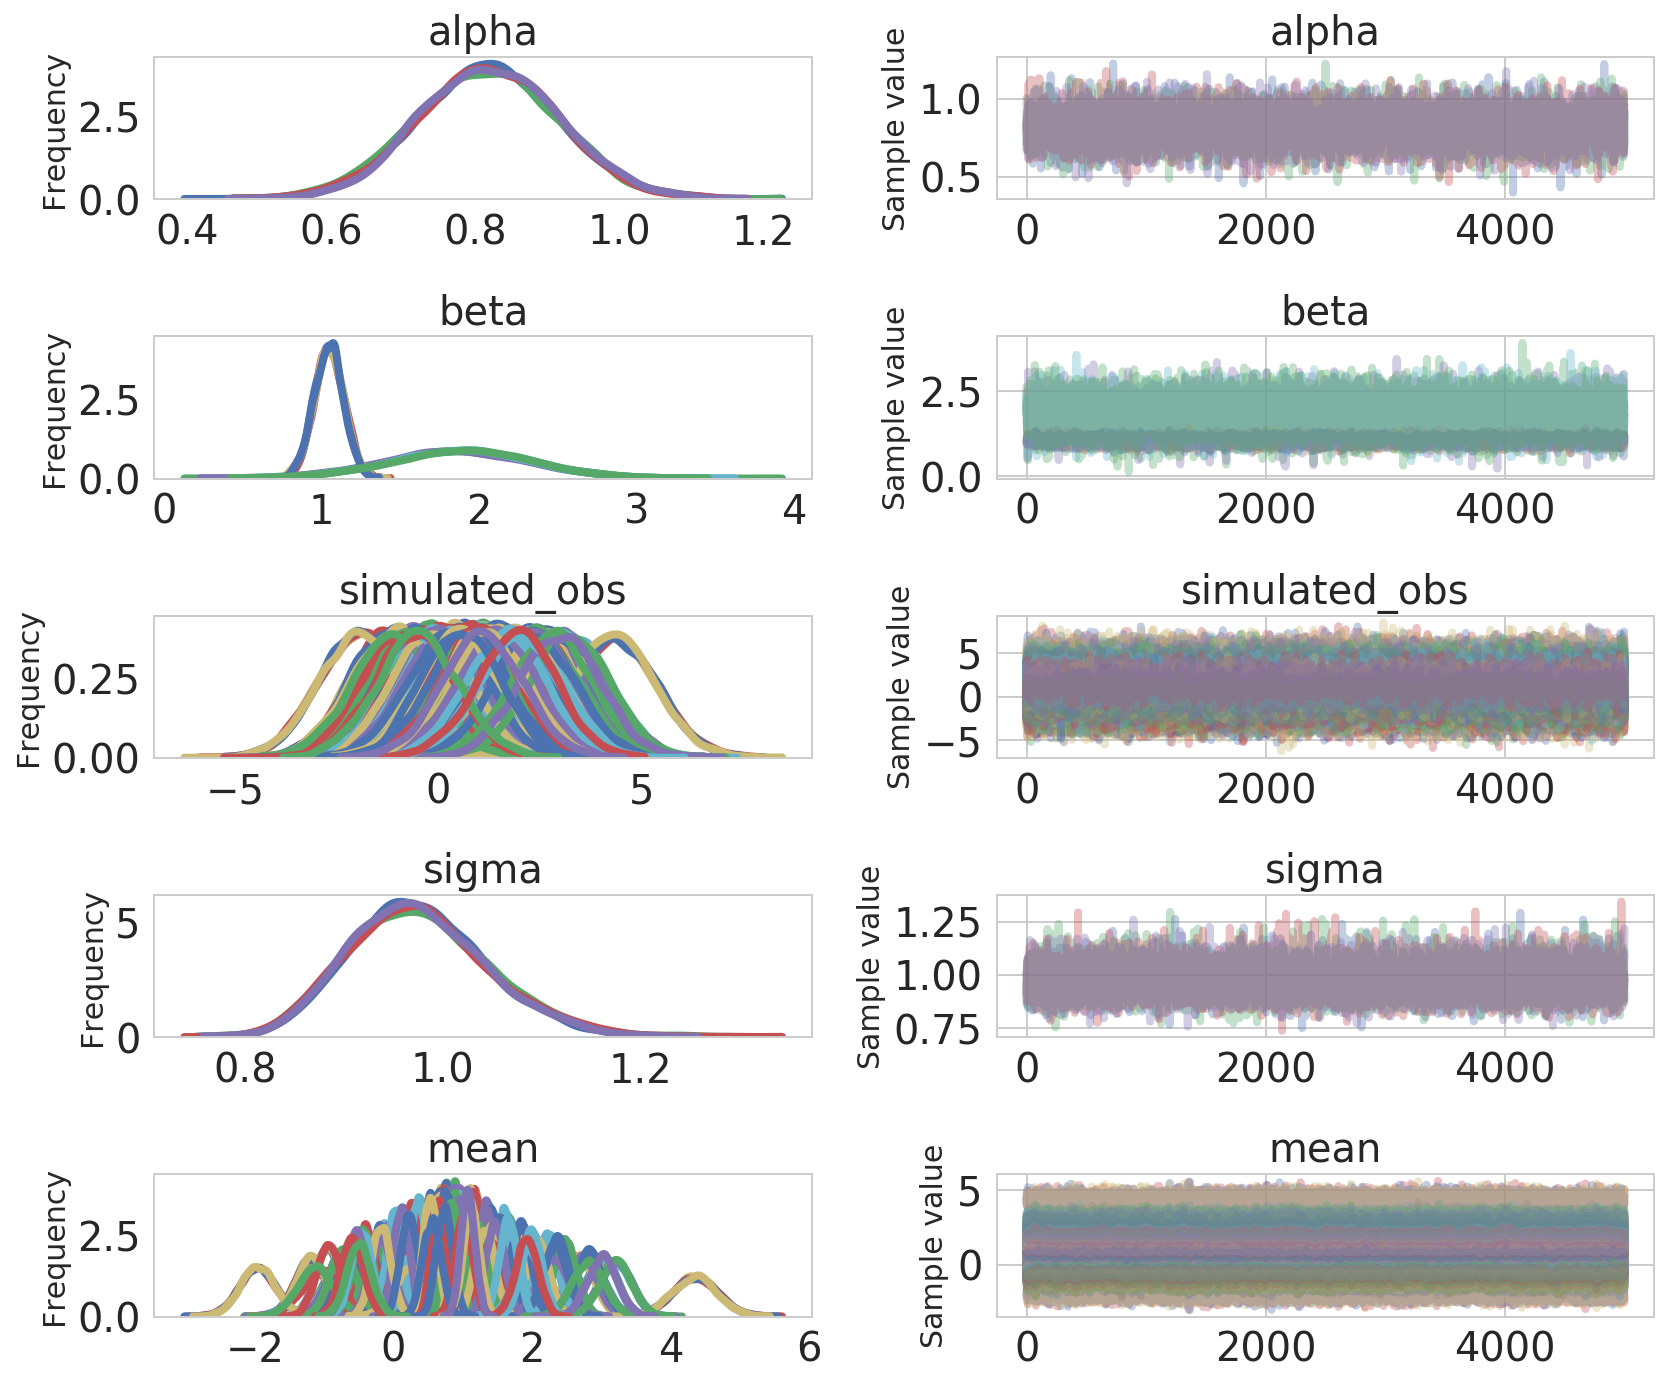

In [80]:
# a traceplot is the most common plot used to analyze sampling results
pm.traceplot(posterior);

In [58]:
# also look at the Gelman-Rubin statistic
pm.gelman_rubin(posterior, varnames = ["alpha", "beta", "sigma"])

{'alpha': 1.0001226941083523,
 'beta': array([1.000053 , 0.9999703], dtype=float32),
 'sigma': 1.0000377113140642}

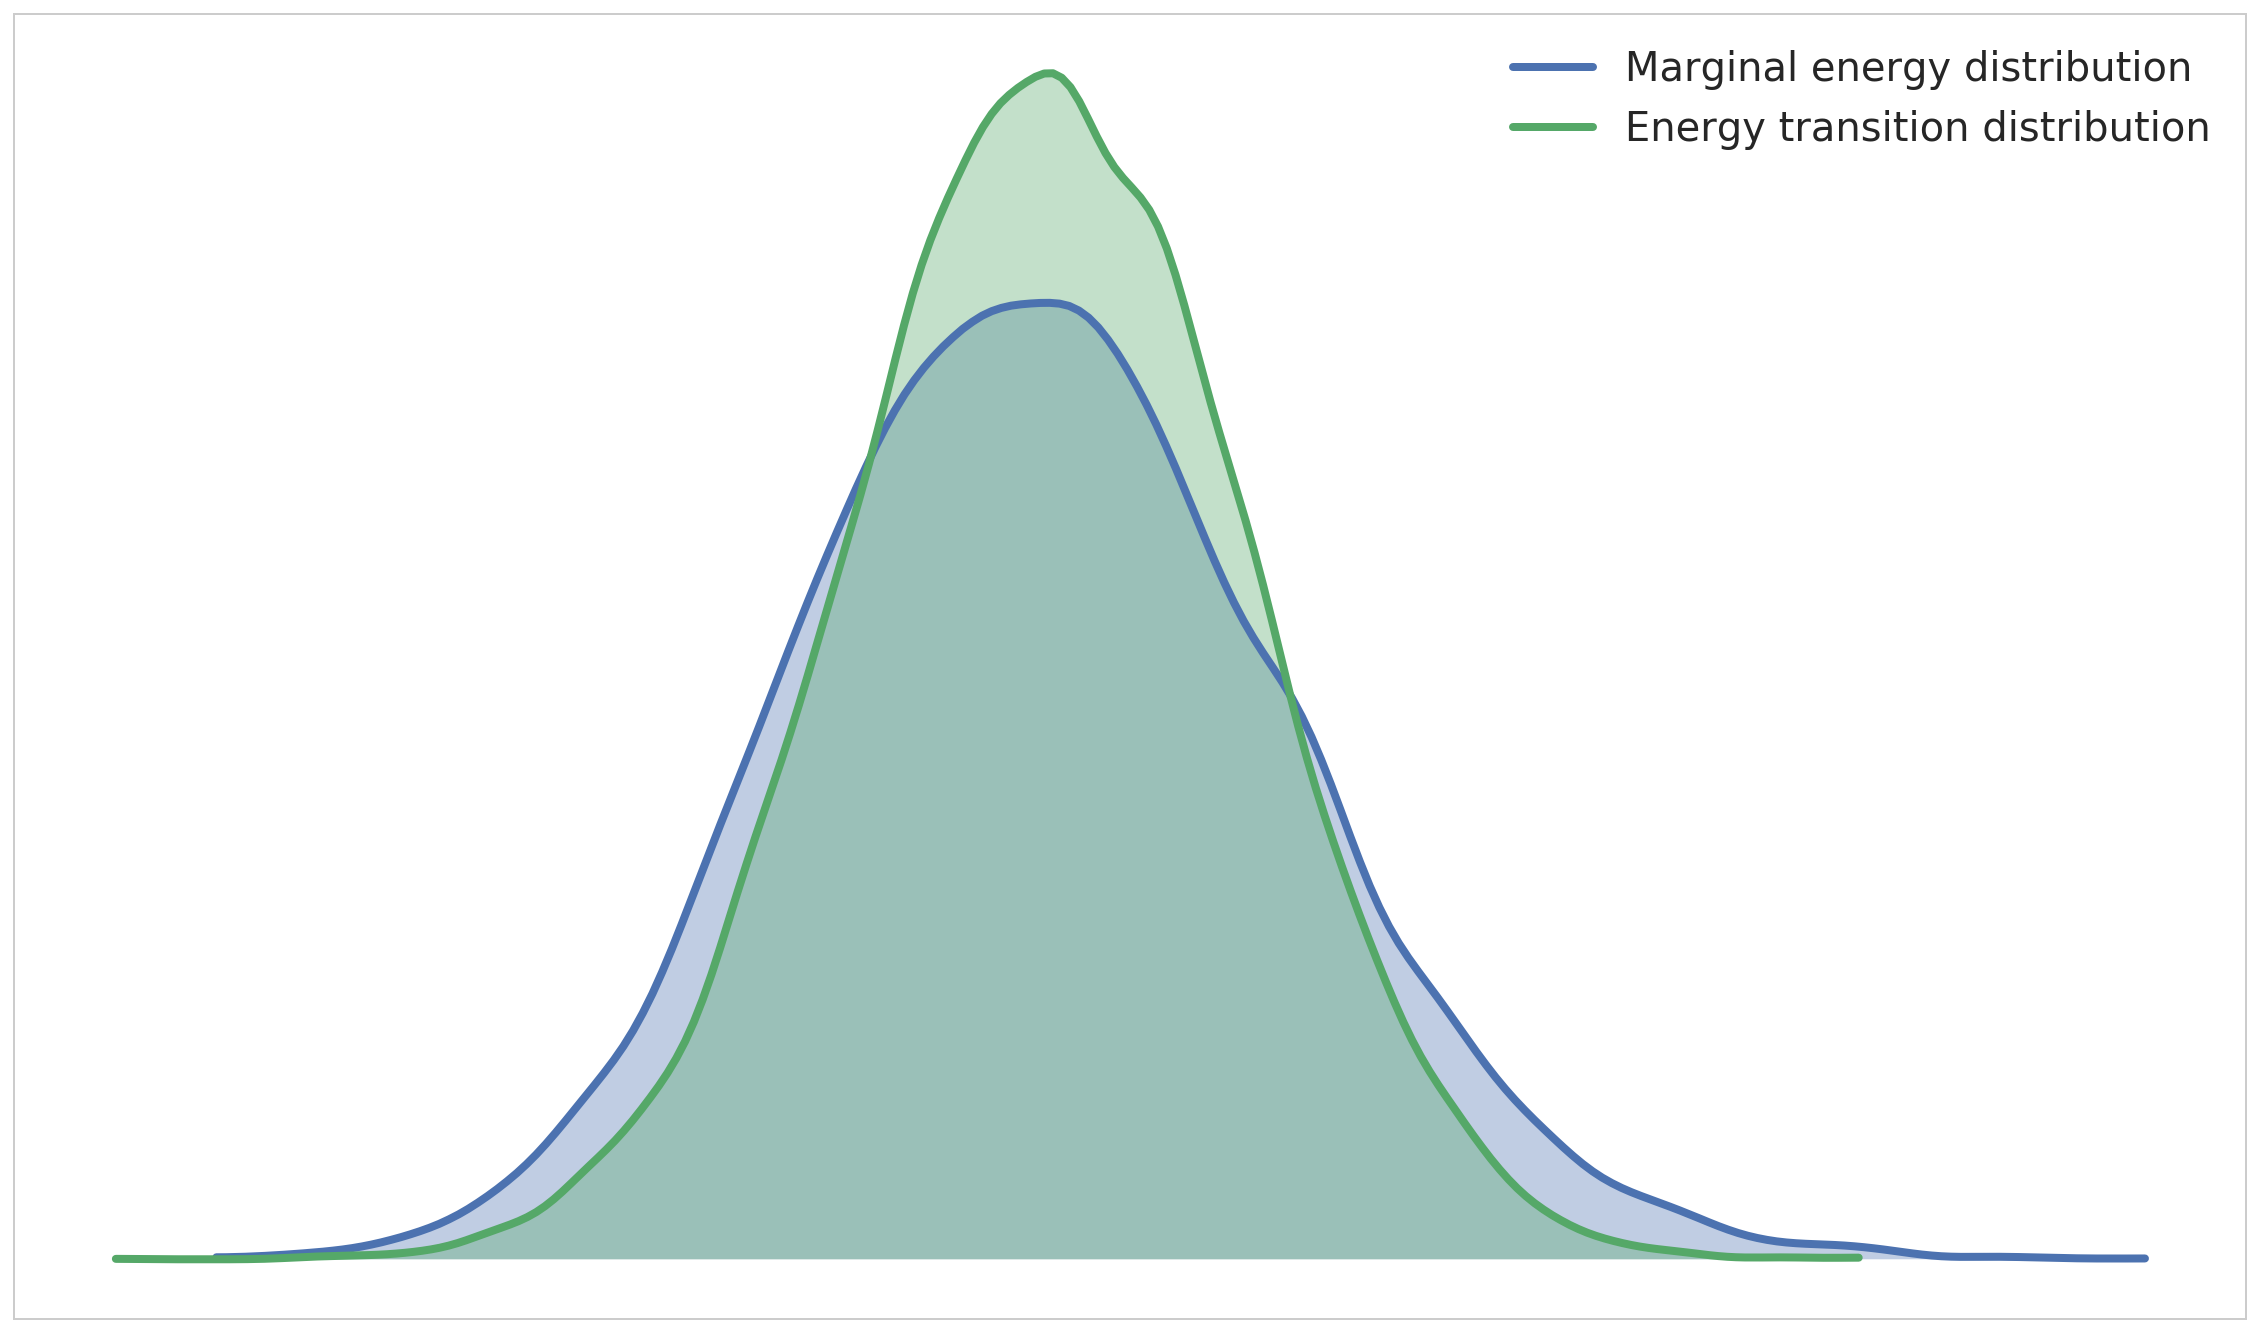

In [59]:
# look at energy plots to assess problems of convergence
pm.energyplot(posterior);

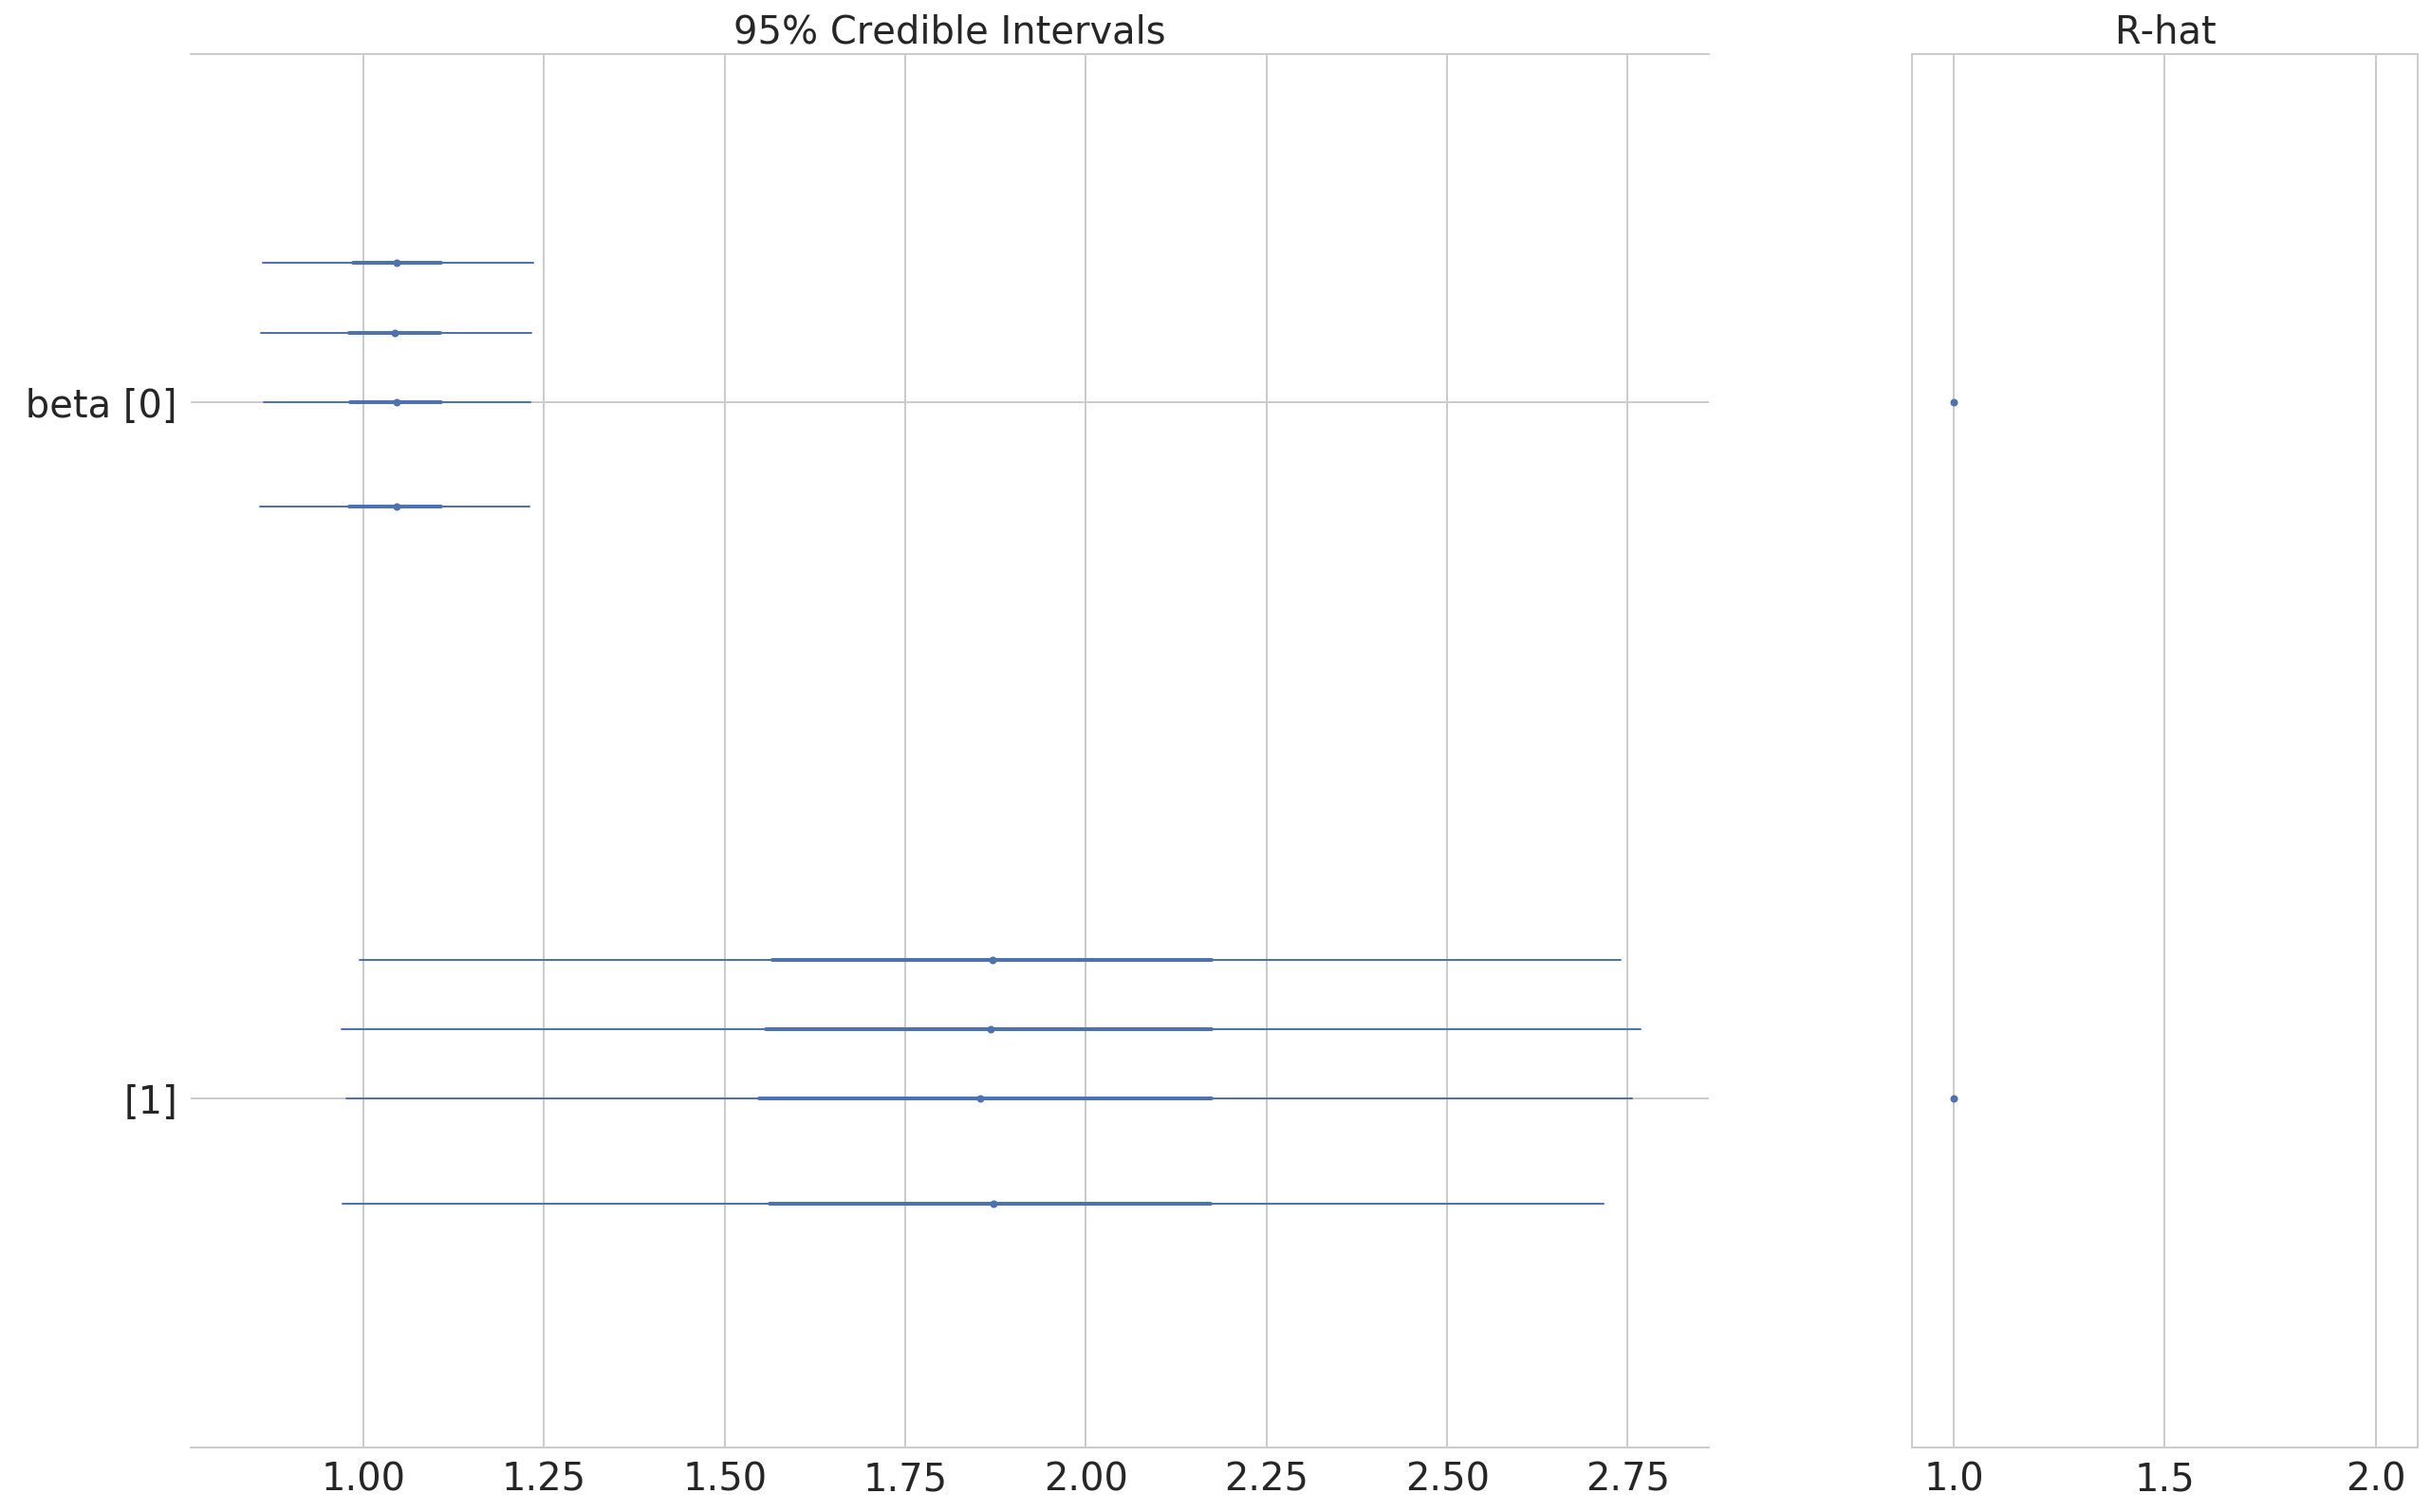

In [60]:
# also look at the forestplot for Rhat values
pm.forestplot(posterior, varnames = ["beta"]);

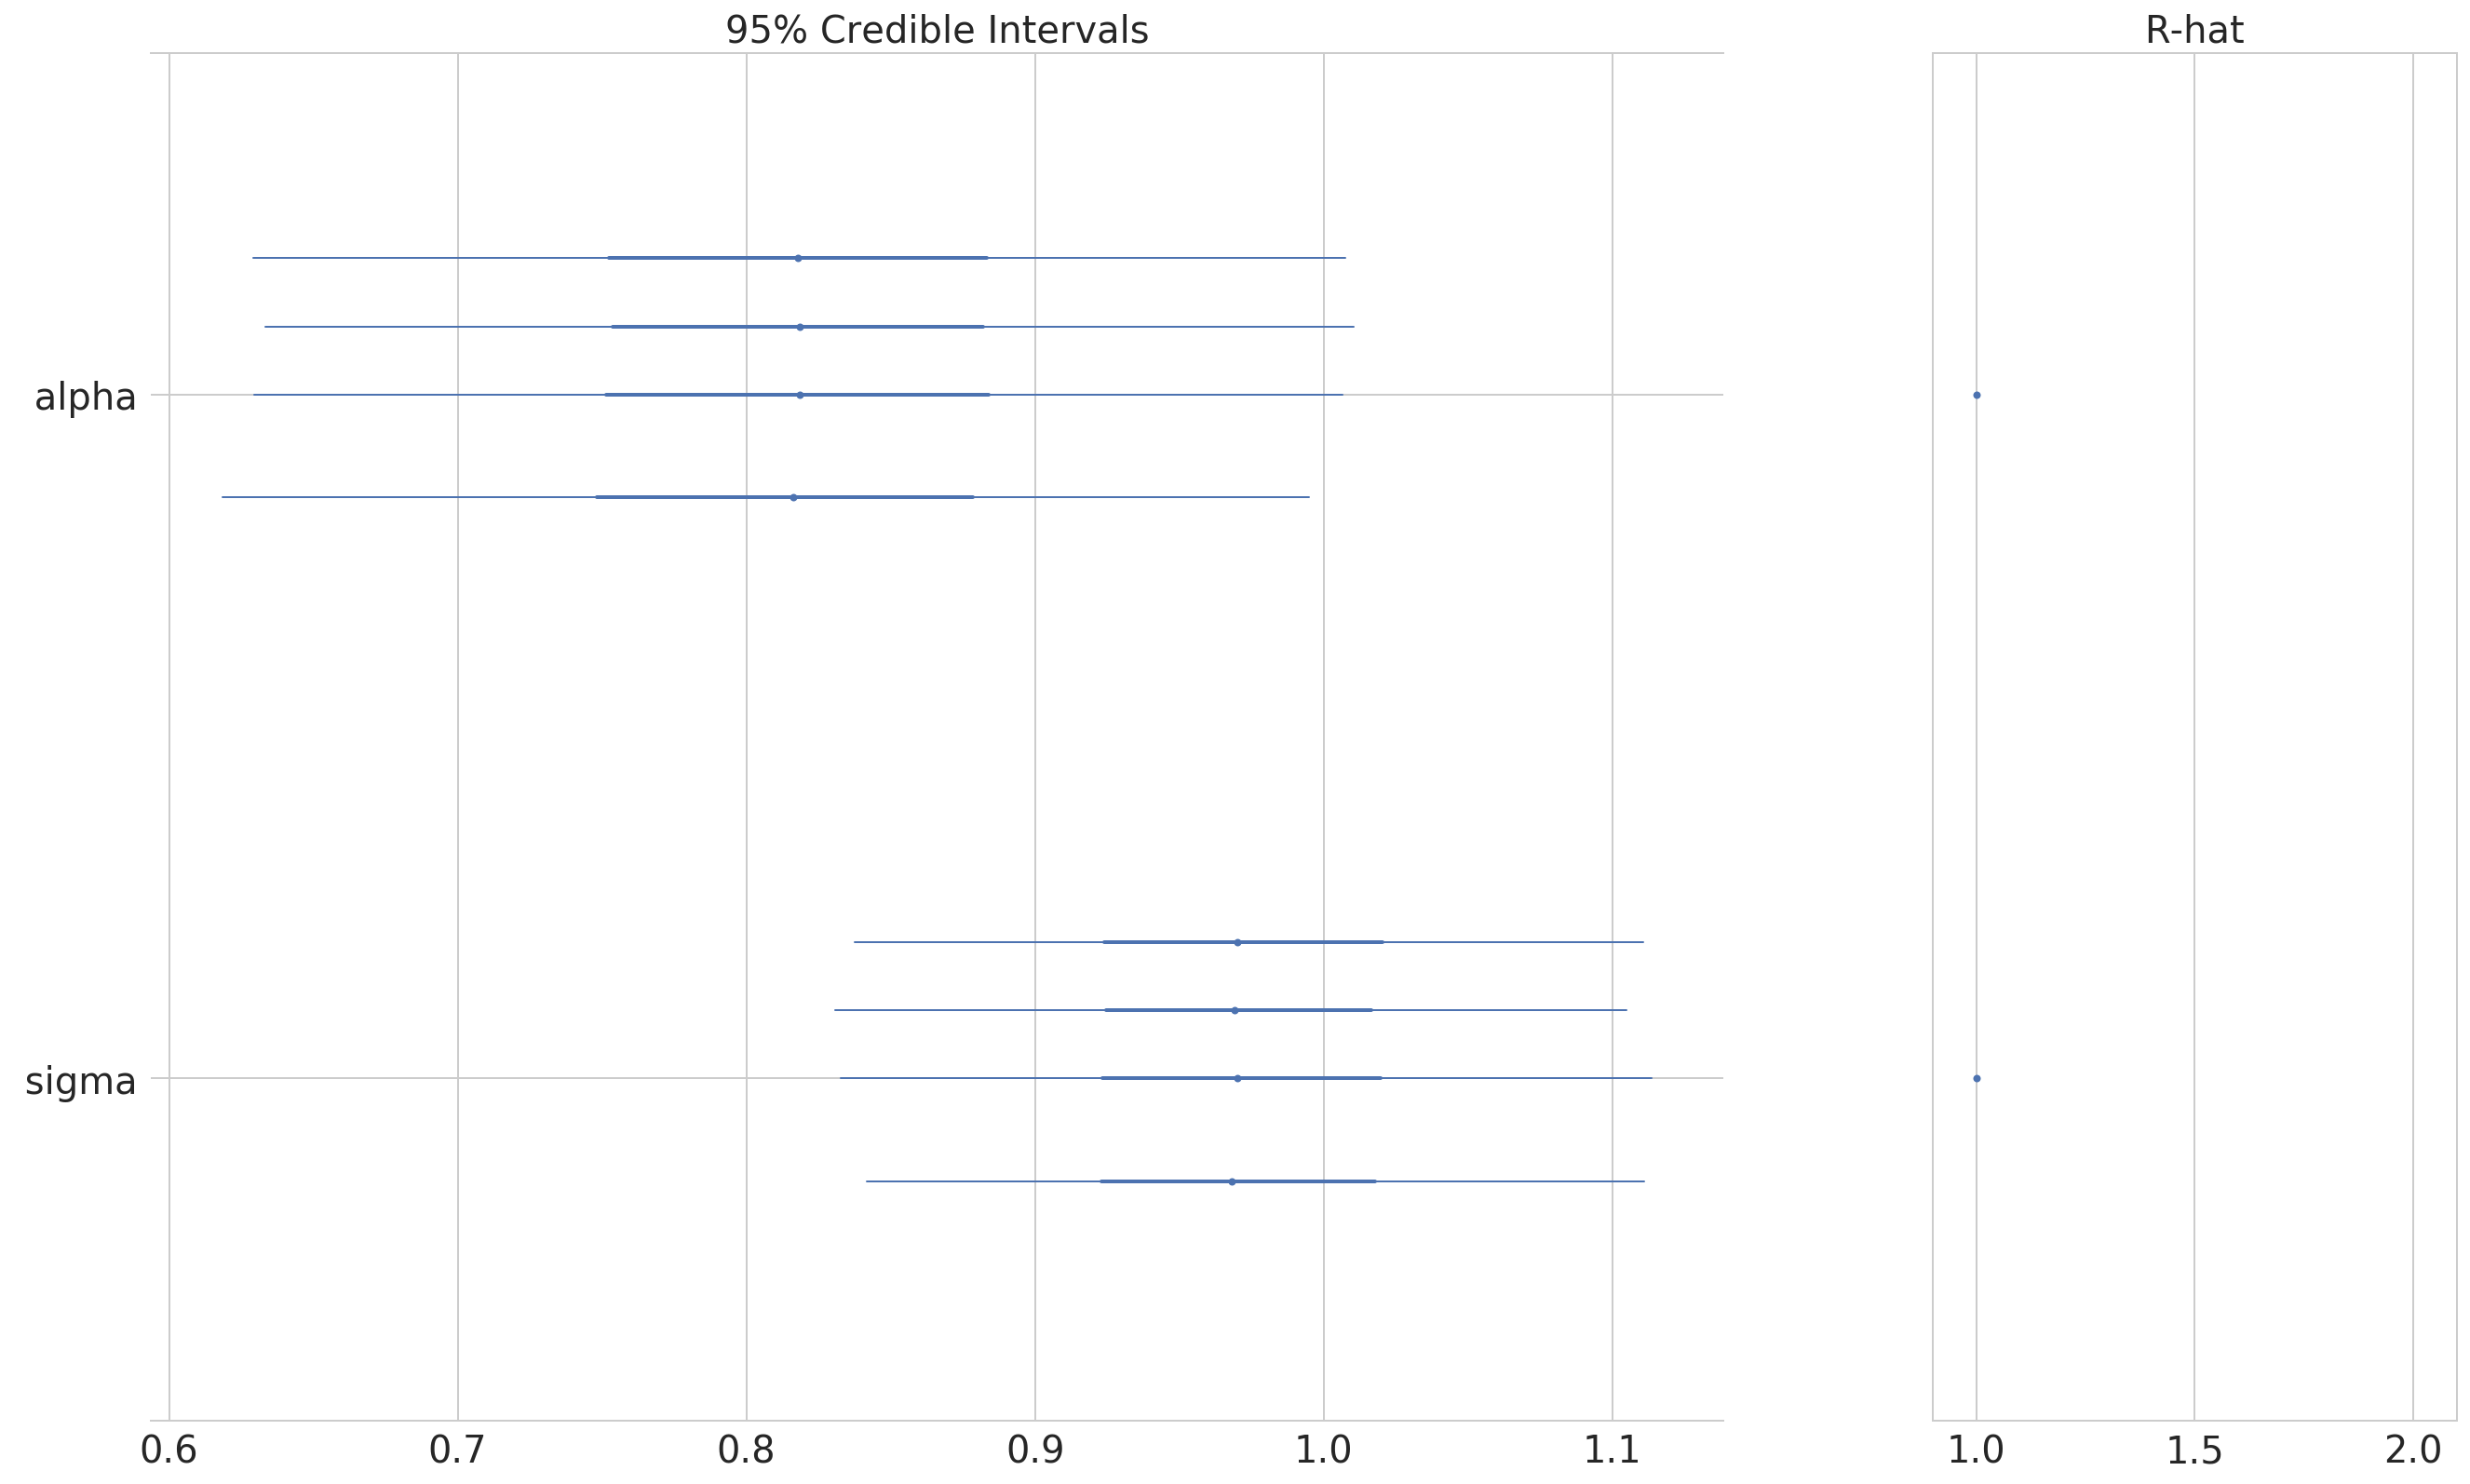

In [61]:
pm.forestplot(posterior, varnames = ["alpha", "sigma"]);

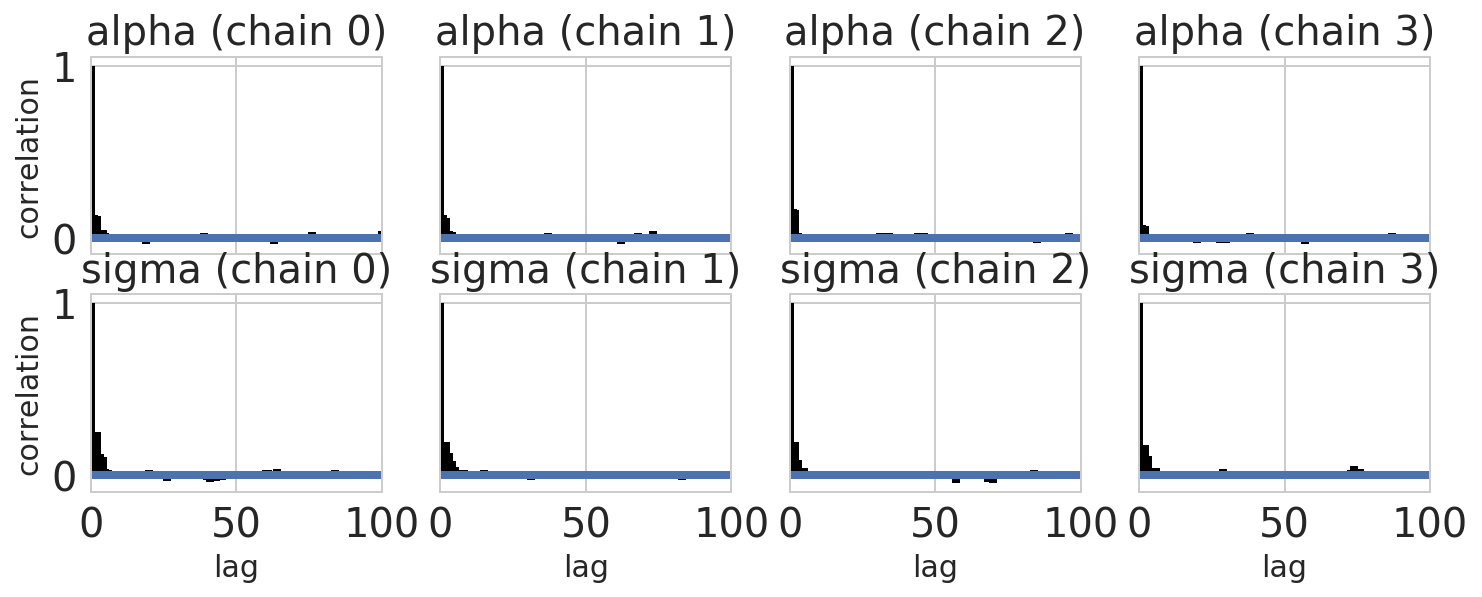

In [63]:
pm.autocorrplot(posterior, varnames = ["alpha", "sigma"]);

### Step 5: Critize the model

In [67]:
pm.df_summary(posterior, varnames = ["alpha", "beta", "sigma"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.816769,0.097000,0.000903,0.617409,0.996309,12401.0,1.000123
beta__0,1.044873,0.094673,0.000825,0.859530,1.232942,13047.0,1.000053
beta__1,1.862676,0.457060,0.003901,0.969313,2.741374,12135.0,0.999970
sigma,0.973322,0.070731,0.000709,0.834846,1.109905,8646.0,1.000038


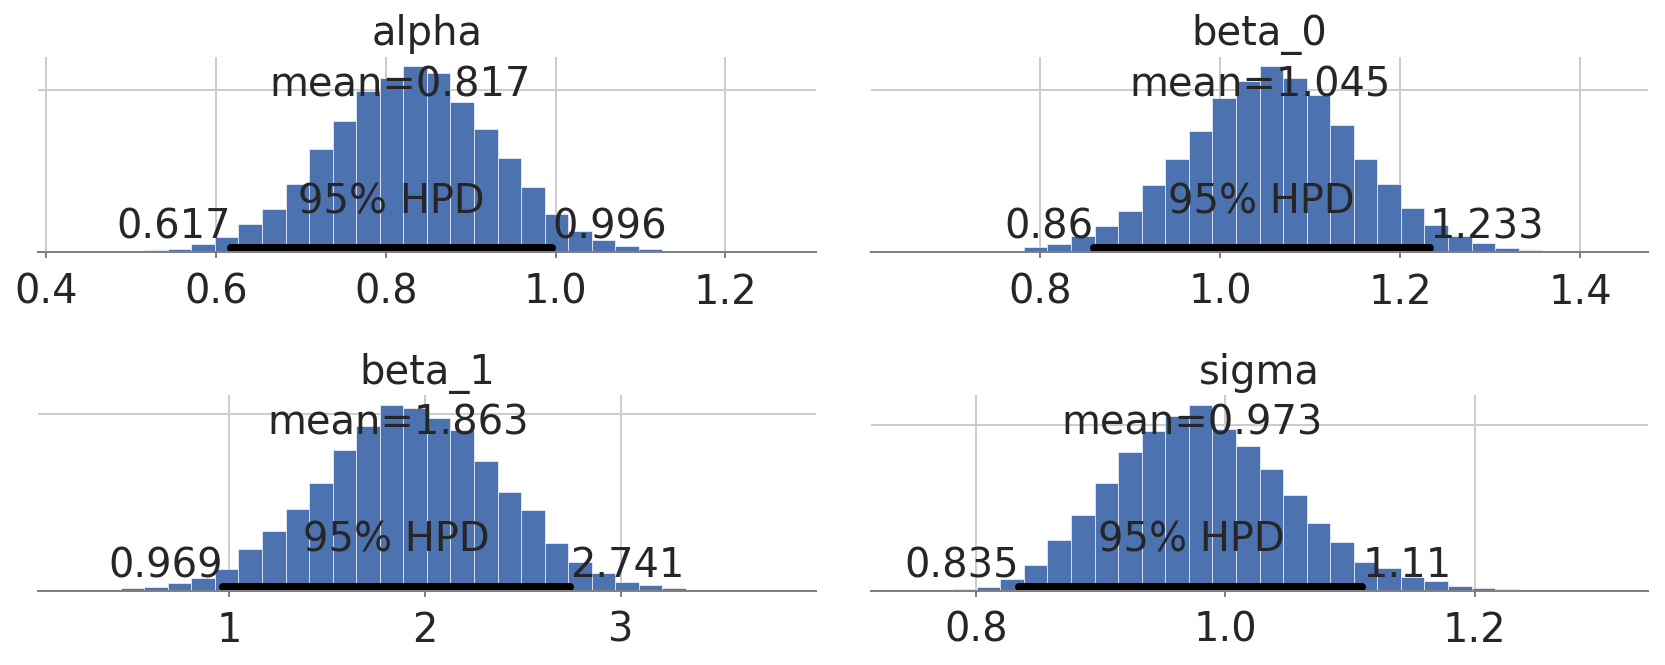

In [68]:
pm.plot_posterior(posterior, varnames = ["alpha", "beta", "sigma"]);

In [69]:
posterior['beta'].shape

(20000, 2)

In [70]:
len(posterior)

5000

In [71]:
posterior.nchains

4

In [72]:
posterior.get_values(varname = 'beta', chains = 1).shape # get values of a single chain

(5000, 2)

In [75]:
# extract the simulated data
simulated_data = posterior["simulated_obs"]
simulated_data.shape

(20000, 100)

### Step 6: Use the model for prediction

In [37]:
new_y = np.random.randn(10)
y.set_value(new_y)

# use pm.sample_ppc to do posterior predictive checks
with model:
    post_pred = pm.sample_ppc(posterior, samples = 1000, size = len(new_y))

100%|██████████| 1000/1000 [00:00<00:00, 1400.40it/s]


In [38]:
post_pred['obs'].shape

(1000, 10)

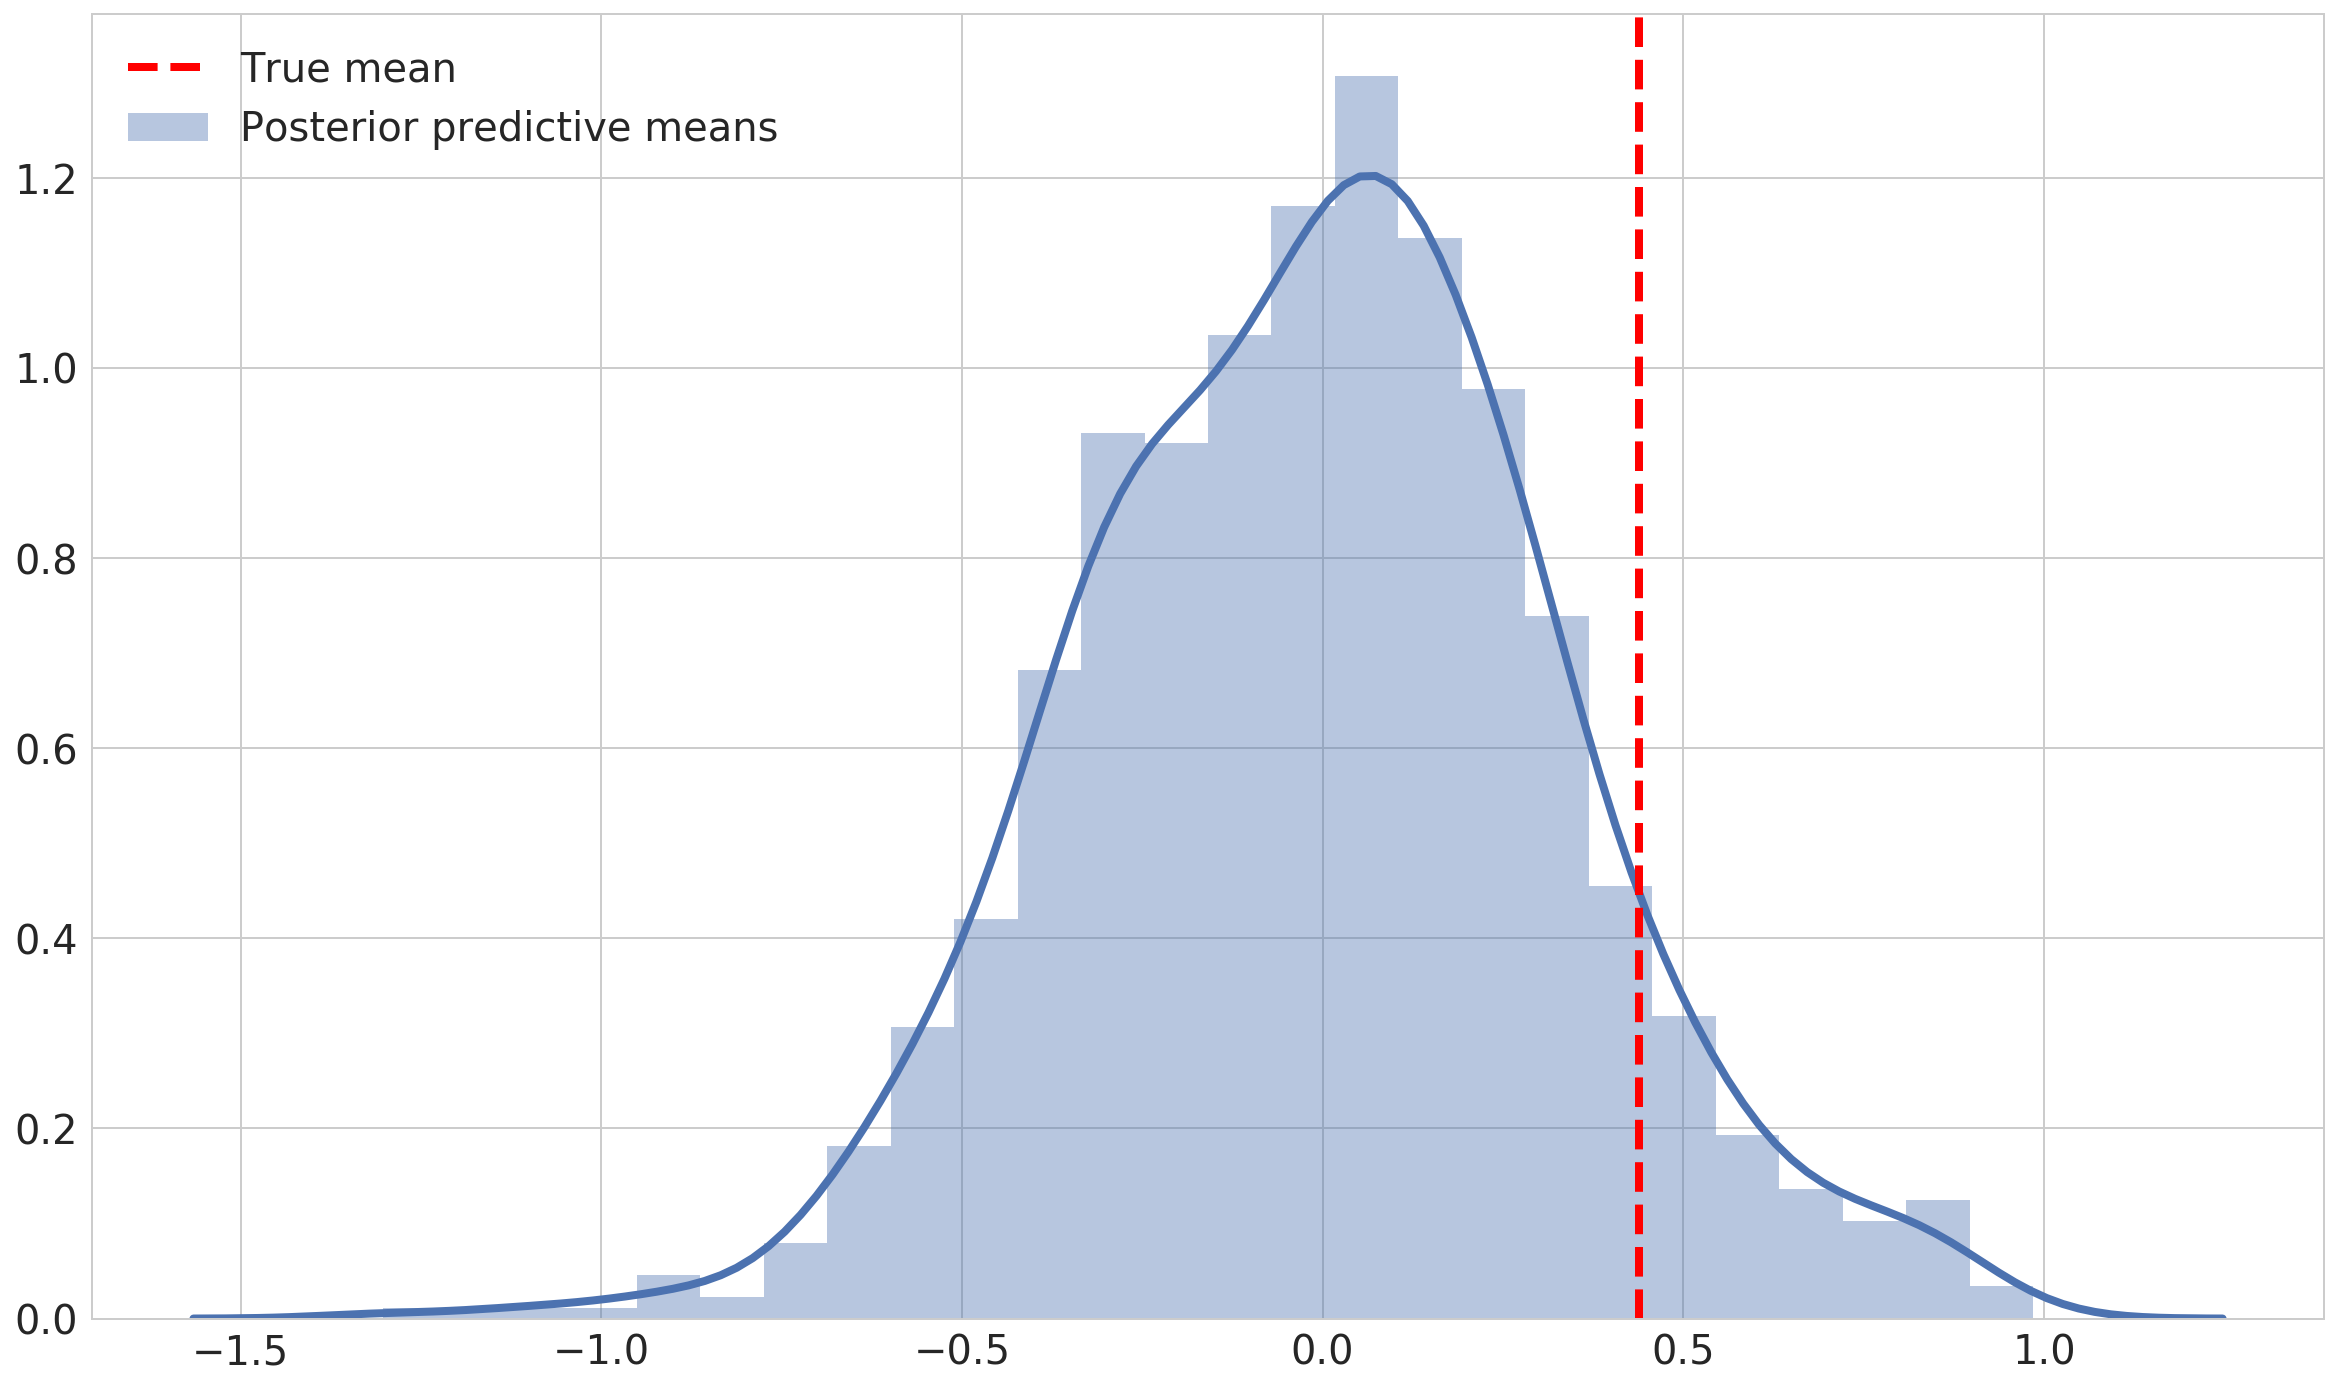

In [52]:
plt.figure()
ax = sns.distplot(post_pred['obs'].mean(axis=1), label='Posterior predictive means')
ax.axvline(new_y.mean(), color='r', ls='--', label='True mean')
ax.legend();

In [ ]:
# save the posterior to the file 'posterior_lm.pkl' for later use
with open('posterior_lm.pkl', 'wb') as f:
    pickle.dump(posterior, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# load it at some future point
with open('posterior_lm.pkl', 'rb') as f:
    posterior = pickle.load(f)

In [77]:
# Dependencies
%load_ext watermark
%watermark -dmvgp numpy,scipy,pandas,matplotlib,seaborn,patsy,pymc3,theano,joblib

2018-04-16 

CPython 3.6.3
IPython 6.2.1

numpy 1.14.1
scipy 1.0.0
pandas 0.22.0
matplotlib 2.1.2
seaborn 0.7.1
patsy 0.4.1
pymc3 3.3
theano 1.0.1
joblib 0.11

compiler   : GCC 7.2.0
system     : Linux
release    : 4.9.87-linuxkit-aufs
machine    : x86_64
processor  : x86_64
CPU cores  : 6
interpreter: 64bit
Git hash   : d9cb2c32d9749e3d20bf56130bd3cdb3c49575f3
